# CONSTANTS

In [1]:
# N_RANGE=[11]; RANDOM_STATES=[17]
# N_RANGE=[5,6,7,8,9,10,11]; RANDOM_STATES=[0, 17]
N_RANGE=range(5, 12); RANDOM_STATES=[0, 3, 5, 8, 11, 16, 17, 20, 21, 24]

RANDOM_ALPHA = True
NUM_ZERO_COLUMNS_TO_HSTACK = 10 # effective only if we hstack-zeros (model name ends with _ZEROS)

trials_out = {}

PLOT_LEARNING_CURVES = True
PLOT_INPUT = True

RUN_DNN = True
RUN_DNN_ZEROS = True
RUN_DNN_WIN_SLIDING_AVG = False
RUN_DNN_WIN_SLIDING_AVG_ZEROS = False
RUN_DNN_SLIDING_SUM = False
RUN_DNN_SLIDING_SUM_ZEROS = False
RUN_DNN_WIN = False
RUN_DNN_WIN_ZEROS = False
RUN_CNN = True
RUN_CNN_ZEROS = True
RUN_CNNM = True

TTEST_NUM_TESTS = 10

# Import function library

In [2]:
%run yulesimon-lib.ipynb

# Debug helpers

In [3]:
def debug_summary(trial):
    if PLOT_INPUT:
        trial_plot_input(trial['input_sample'])
    if PLOT_LEARNING_CURVES:
        trial_plot_learning_curves(trial)

# helper function to plot learning curves for the given trial output
def trial_plot_learning_curves(trial):
    history_path = '{}.history'.format(trial['base_path'])
    history = pickle.load(open(history_path, 'rb'))
    plot_learning_curves(history)

# helper function to plot input shape
def trial_plot_input(x):
    z = x.flatten()
    _ = plt.scatter(range(len(z)), z, s=5, color="blue", label="original")

# DNN

Processing...

input.shape: (10000, 34)
N: 32  avg_sqrt_mse = 0.04326

input.shape: (10000, 20)
N: 64  avg_sqrt_mse = 0.01430

input.shape: (10000, 46)
N: 128  avg_sqrt_mse = 0.01480

input.shape: (10000, 21)
N: 256  avg_sqrt_mse = 0.01041

input.shape: (10000, 33)
N: 512  avg_sqrt_mse = 0.00908

input.shape: (10000, 63)
N: 1024  avg_sqrt_mse = 0.00985

input.shape: (10000, 140)
N: 2048  avg_sqrt_mse = 0.01002

loss: 0.00323218
val_loss: 0.00001909
CPU times: user 1h 23min 13s, sys: 8min 14s, total: 1h 31min 28s
Wall time: 36min 49s


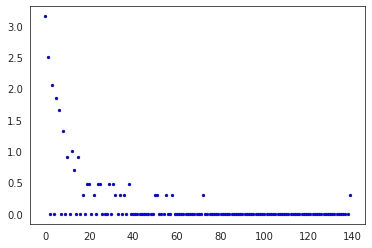

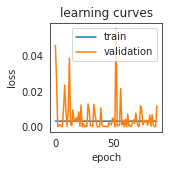

In [4]:
%%time
if RUN_DNN:
    nn = 'DNN'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])


# DNN zeros

Processing...

input.shape: (10000, 34)
N: 32  avg_sqrt_mse = 0.04341

input.shape: (10000, 20)
N: 64  avg_sqrt_mse = 0.01435

input.shape: (10000, 46)
N: 128  avg_sqrt_mse = 0.01506

input.shape: (10000, 21)
N: 256  avg_sqrt_mse = 0.01066

input.shape: (10000, 33)
N: 512  avg_sqrt_mse = 0.00798

input.shape: (10000, 63)
N: 1024  avg_sqrt_mse = 0.01143

input.shape: (10000, 140)
N: 2048  avg_sqrt_mse = 0.00789

loss: 0.00322374
val_loss: 0.00003424
CPU times: user 1h 19min 50s, sys: 7min 30s, total: 1h 27min 21s
Wall time: 35min 1s


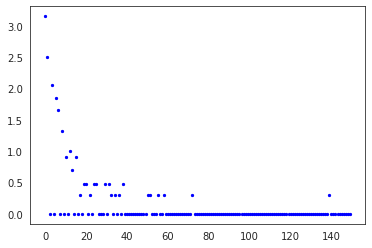

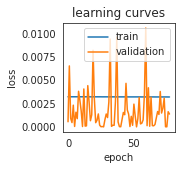

In [5]:
%%time
if RUN_DNN_ZEROS:
    nn = 'DNN_ZEROS'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# DNN sliding-avg test

In [6]:
X_moving_avg_test = np.array([ [1,2,3,4,5,6,7], [1,2,3,4,5,6,7] ])

print('X_moving_avg_test:')
print(X_moving_avg_test)

OUT_moving_avg_test, window_sizes = data_hstack_moving_avg(X_moving_avg_test)

print()
print('window_sizes:', window_sizes)

print()
print('OUT_moving_avg_test:')
print(OUT_moving_avg_test)

X_moving_avg_test:
[[1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7]]

window_sizes: [2, 4]

OUT_moving_avg_test:
[[1.  2.  3.  4.  5.  6.  7.  1.5 2.5 3.5 4.5 5.5 6.5 2.5 3.5 4.5 5.5]
 [1.  2.  3.  4.  5.  6.  7.  1.5 2.5 3.5 4.5 5.5 6.5 2.5 3.5 4.5 5.5]]


# DNN sliding-avg

In [7]:
%%time
if RUN_DNN_WIN_SLIDING_AVG:
    nn = 'DNN_SLIDING_AVG'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs


# DNN sliding-avg zeros

In [8]:
%%time
if RUN_DNN_WIN_SLIDING_AVG_ZEROS:
    nn = 'DNN_SLIDING_AVG'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs


# DNN sliding-sum

In [9]:
%%time
if RUN_DNN_SLIDING_SUM:
    nn = 'DNN_SLIDING_SUM'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs


# DNN sliding-sum zeros

In [10]:
%%time
if RUN_DNN_SLIDING_SUM_ZEROS:
    nn = 'DNN_SLIDING_SUM_ZEROS'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs


# DNN win test
Test to show that 'data_hstack_win_sum()' is working correctly

In [11]:
X_win_test = np.array([ [1,2,3,4,5,6,7], [1,2,3,4,5,6,7] ])

print('X_win_test:')
print(X_win_test)

OUT_win_test, window_sizes = data_hstack_win_sum(X_win_test)

print()
print('window_sizes:', window_sizes)

print()
print('OUT_win_test:')
print(OUT_win_test)

X_win_test:
[[1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7]]

window_sizes: [2, 4]

OUT_win_test:
[[ 1  2  3  4  5  6  7  3  7 11 10]
 [ 1  2  3  4  5  6  7  3  7 11 10]]


# DNN win

In [12]:
%%time
if RUN_DNN_WIN:
    nn = 'DNN_WIN'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs


# DNN win zeros

In [13]:
%%time
if RUN_DNN_WIN_ZEROS:
    nn = 'DNN_WIN_ZEROS'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs


# CNN

Processing...

input.shape: (10000, 34)
N: 32  avg_sqrt_mse = 0.04104

input.shape: (10000, 20)
N: 64  avg_sqrt_mse = 0.01080

input.shape: (10000, 46)
N: 128  avg_sqrt_mse = 0.01146

input.shape: (10000, 21)
N: 256  avg_sqrt_mse = 0.00498

input.shape: (10000, 33)
N: 512  avg_sqrt_mse = 0.00365

input.shape: (10000, 63)
N: 1024  avg_sqrt_mse = 0.00219

input.shape: (10000, 140)
N: 2048  avg_sqrt_mse = 0.00122

loss: 0.00000062
val_loss: 0.00000048
CPU times: user 1h 7min 47s, sys: 4min 55s, total: 1h 12min 42s
Wall time: 36min 16s


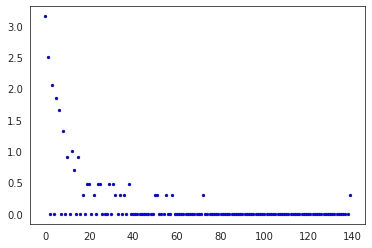

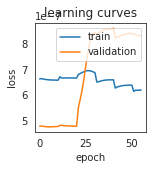

In [14]:
%%time
if RUN_CNN:
    nn = 'CNN'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# CNN zeros

Processing...

input.shape: (10000, 34)
N: 32  avg_sqrt_mse = 0.04111

input.shape: (10000, 20)
N: 64  avg_sqrt_mse = 0.01085

input.shape: (10000, 46)
N: 128  avg_sqrt_mse = 0.01161

input.shape: (10000, 21)
N: 256  avg_sqrt_mse = 0.00483

input.shape: (10000, 33)
N: 512  avg_sqrt_mse = 0.00329

input.shape: (10000, 63)
N: 1024  avg_sqrt_mse = 0.00229

input.shape: (10000, 140)
N: 2048  avg_sqrt_mse = 0.00110

loss: 0.00000067
val_loss: 0.00000051
CPU times: user 1h 17min 44s, sys: 5min 32s, total: 1h 23min 17s
Wall time: 40min 44s


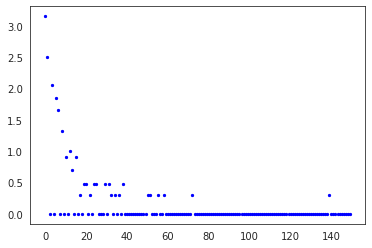

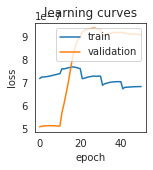

In [15]:
%%time
if RUN_CNN_ZEROS:
    nn = 'CNN_ZEROS'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# CNN multi-layer

Processing...

input.shape: (10000, 34)
N: 32  avg_sqrt_mse = 0.04107

input.shape: (10000, 20)
N: 64  avg_sqrt_mse = 0.01101

input.shape: (10000, 46)
N: 128  avg_sqrt_mse = 0.01064

input.shape: (10000, 21)
N: 256  avg_sqrt_mse = 0.00453

input.shape: (10000, 33)
N: 512  avg_sqrt_mse = 0.00272

input.shape: (10000, 63)
N: 1024  avg_sqrt_mse = 0.00153

input.shape: (10000, 140)
N: 2048  avg_sqrt_mse = 0.00104

loss: 0.00000091
val_loss: 0.00000075
CPU times: user 2h 30min 5s, sys: 8min 31s, total: 2h 38min 37s
Wall time: 51min 9s


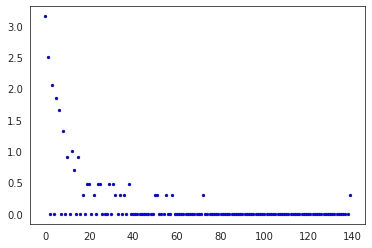

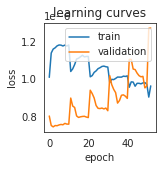

In [16]:
%%time
if RUN_CNNM:
    nn = 'CNNM'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# CNN multi-layer + zeros

Processing...

input.shape: (10000, 34)
N: 32  avg_sqrt_mse = 0.04123

input.shape: (10000, 20)
N: 64  avg_sqrt_mse = 0.01088

input.shape: (10000, 46)
N: 128  avg_sqrt_mse = 0.01107

input.shape: (10000, 21)
N: 256  avg_sqrt_mse = 0.00455

input.shape: (10000, 33)
N: 512  avg_sqrt_mse = 0.00282

input.shape: (10000, 63)
N: 1024  avg_sqrt_mse = 0.00213

input.shape: (10000, 140)
N: 2048  avg_sqrt_mse = 0.00111

loss: 0.00000106
val_loss: 0.00000076
CPU times: user 3h 12min 31s, sys: 10min 18s, total: 3h 22min 49s
Wall time: 1h 4min 3s


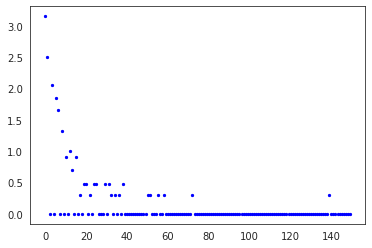

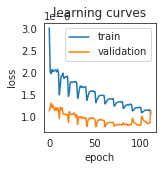

In [17]:
%%time
if RUN_CNNM:
    nn = 'CNNM_ZEROS'
    trials_out[nn] = trial(nn=nn, N_range=N_RANGE, random_states=RANDOM_STATES)
    debug_summary(trials_out[nn])

# plot log(N) vs sqrt_mse (all trials)

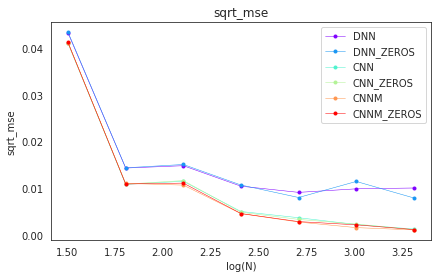

In [18]:
def plot_sqrt_mse(plot_std=False):
    
    plt.figure(figsize=(15, 4))
    
    ax1 = plt.subplot(1, 2, 1)

    ax1.set(title='sqrt_mse', xlabel='log(N)', ylabel='sqrt_mse')

    colors = iter(cm.rainbow(np.linspace(0, 1, len(trials_out))))

    for trial in trials_out:
        out = trials_out[trial]
        x = np.log10(out['a_N'])
        y = out['a_sqrt_mse']
        c = next(colors)
        ax1.plot(x, y, linewidth=0.5, c=c, marker='o', markersize=3, label=trial)
        if plot_std:
            std = out['a_std_abs_errors']
            ax1.fill_between(x, y - std, y + std, facecolor=colors[i], alpha=0.3)
    
    plt.legend(loc='upper right')

plot_sqrt_mse()


# print and save statistics (yulesimon.csv)

In [19]:
dict_list = []
for trial in trials_out:
    t = trials_out[trial]
    dict_list.append(('N', t['a_N']))
for trial in trials_out:
    t = trials_out[trial]
    dict_list.append(('sqrt_mse_{}'.format(trial), t['a_sqrt_mse']))
for trial in trials_out:
    t = trials_out[trial]
    dict_list.append(('std_{}'.format(trial), t['a_std_abs_errors']))
for trial in trials_out:
    t = trials_out[trial]
    dict_list.append(('avg_abs_error_{}'.format(trial), t['a_avg_abs_errors']))

df = pd.DataFrame(dict(dict_list))

df = df.set_index('N')

df.to_csv('yulesimon.csv', float_format='%.5f')

columns=[]
for t in trials_out:
    columns.append(('sqrt_MSE', trial))
for t in trials_out:
    columns.append(('STD', trial))
for t in trials_out:
    columns.append(('avg_abs_err', trial))

df.columns=pd.MultiIndex.from_tuples(columns)

print('err = y_test - y_pred')
df

err = y_test - y_pred


sqrt_MSE                                                         \
     CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS   
N                                                                        
32     0.043260   0.043405   0.041040   0.041108   0.041068   0.041231   
64     0.014299   0.014351   0.010801   0.010851   0.011011   0.010877   
128    0.014803   0.015061   0.011461   0.011613   0.010644   0.011070   
256    0.010409   0.010662   0.004984   0.004832   0.004527   0.004551   
512    0.009084   0.007984   0.003653   0.003293   0.002724   0.002817   
1024   0.009846   0.011425   0.002195   0.002291   0.001530   0.002129   
2048   0.010022   0.007886   0.001215   0.001096   0.001038   0.001111   

            STD                                                         \
     CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS   
N                                                                        
32     0.023159   0.023944   0.025286   0.025220   0.025077   0.025169   
64     0.006112   0.005835   0.007213   0.007136   0.007141   0.007187   
128    0.007661   0.007169   0.007652   0.007497   0.006589   0.006661   
256    0.003591   0.002905   0.003501   0.003425   0.002946   0.002983   
512    0.002553   0.002169   0.002071   0.002125   0.001697   0.001740   
1024   0.001992   0.003733   0.001593   0.001700   0.001010   0.001097   
2048   0.003038   0.001441   0.000609   0.000606   0.000556   0.000643   

     avg_abs_err                                                         
      CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS CNNM_ZEROS  
N                                                                        
32      0.034554   0.034369   0.031745   0.031799   0.031906   0.031936  
64      0.011205   0.011350   0.007880   0.007954   0.007995   0.007879  
128     0.011365   0.011263   0.008075   0.008314   0.007473   0.007897  
256     0.008288   0.008538   0.003397   0.003287   0.003115   0.003023  
512     0.007459   0.006467   0.002613   0.002235   0.001840   0.001933  
1024    0.008150   0.009331   0.001378   0.001408   0.001034   0.001456  
2048    0.008145   0.006504   0.000886   0.000767   0.000748   0.000769

## $mse$ comparison

In [20]:
dict_list_mse = []
for trial in trials_out:
    t = trials_out[trial]
    dict_list_mse.append(('N', t['a_N']))
    dict_list_mse.append((f'{trial}', t['a_sqrt_mse']))

df = pd.DataFrame(dict(dict_list_mse))

df = df.set_index('N')

df

,DNN,DNN_ZEROS,CNN,CNN_ZEROS,CNNM,CNNM_ZEROS
N,,,,,,
32,0.043260,0.043405,0.041040,0.041108,0.041068,0.041231
64,0.014299,0.014351,0.010801,0.010851,0.011011,0.010877
128,0.014803,0.015061,0.011461,0.011613,0.010644,0.011070
256,0.010409,0.010662,0.004984,0.004832,0.004527,0.004551
512,0.009084,0.007984,0.003653,0.003293,0.002724,0.002817
1024,0.009846,0.011425,0.002195,0.002291,0.001530,0.002129
2048,0.010022,0.007886,0.001215,0.001096,0.001038,0.001111


## $STD$ comparison

In [21]:
dict_list_std = []
for trial in trials_out:
    t = trials_out[trial]
    dict_list_std.append(('N', t['a_N']))
    dict_list_std.append((f'{trial}', t['a_std_abs_errors']))

df = pd.DataFrame(dict(dict_list_std))

df = df.set_index('N')
print(df)

           DNN  DNN_ZEROS       CNN  CNN_ZEROS      CNNM  CNNM_ZEROS
N                                                                   
32    0.023159   0.023944  0.025286   0.025220  0.025077    0.025169
64    0.006112   0.005835  0.007213   0.007136  0.007141    0.007187
128   0.007661   0.007169  0.007652   0.007497  0.006589    0.006661
256   0.003591   0.002905  0.003501   0.003425  0.002946    0.002983
512   0.002553   0.002169  0.002071   0.002125  0.001697    0.001740
1024  0.001992   0.003733  0.001593   0.001700  0.001010    0.001097
2048  0.003038   0.001441  0.000609   0.000606  0.000556    0.000643


## T-TEST

In [22]:
t, p = model_compare(nn1='DNN', nn2='CNN', num_tests=TTEST_NUM_TESTS, N_pow=6)

generating data, random-state: 91
input.shape: (10000, 13)
training model: DNN...
sqrt_mse: 0.015806516632437706
training model: CNN...
sqrt_mse: 0.014669310301542282
generating data, random-state: 10
input.shape: (10000, 15)
training model: DNN...
sqrt_mse: 0.02336922101676464
training model: CNN...
sqrt_mse: 0.022210270166397095
generating data, random-state: 73
input.shape: (10000, 20)
training model: DNN...
sqrt_mse: 0.03428180143237114
training model: CNN...
sqrt_mse: 0.03397931903600693
generating data, random-state: 35
input.shape: (10000, 18)
training model: DNN...
sqrt_mse: 0.02048092521727085
training model: CNN...
sqrt_mse: 0.019196897745132446
generating data, random-state: 70
input.shape: (10000, 26)
training model: DNN...
sqrt_mse: 0.018664028495550156
training model: CNN...
sqrt_mse: 0.02234259620308876
generating data, random-state: 15
input.shape: (10000, 10)
training model: DNN...
sqrt_mse: 0.030891451984643936
training model: CNN...
sqrt_mse: 0.029560349881649017
gen

In [23]:
t, p = model_compare(nn1='DNN', nn2='CNN', num_tests=5, N_pow=6)

generating data, random-state: 91
input.shape: (10000, 13)
training model: DNN...
sqrt_mse: 0.015806516632437706
training model: CNN...
sqrt_mse: 0.014669310301542282
generating data, random-state: 10
input.shape: (10000, 15)
training model: DNN...
sqrt_mse: 0.02336922101676464
training model: CNN...
sqrt_mse: 0.022210270166397095
generating data, random-state: 73
input.shape: (10000, 20)
training model: DNN...
sqrt_mse: 0.03428180143237114
training model: CNN...
sqrt_mse: 0.03397931903600693
generating data, random-state: 35
input.shape: (10000, 18)
training model: DNN...
sqrt_mse: 0.02048092521727085
training model: CNN...
sqrt_mse: 0.019196897745132446
generating data, random-state: 70
input.shape: (10000, 26)
training model: DNN...
sqrt_mse: 0.018664028495550156
training model: CNN...
sqrt_mse: 0.02234259620308876
avg(sqrt_mse): 0.02252
avg(sqrt_mse): 0.02248
a: [0.015806517, 0.023369221, 0.0342818, 0.020480925, 0.018664028]
b: [0.01466931, 0.02221027, 0.03397932, 0.019196898, 0.02

In [24]:
t, p = model_compare(nn1='DNN', nn2='CNN', num_tests=5, N_pow=7)

generating data, random-state: 15
input.shape: (10000, 16)
training model: DNN...
sqrt_mse: 0.019053146243095398
training model: CNN...
sqrt_mse: 0.018810657784342766
generating data, random-state: 26
input.shape: (10000, 19)
training model: DNN...
sqrt_mse: 0.013120359741151333
training model: CNN...
sqrt_mse: 0.011800708249211311
generating data, random-state: 95
input.shape: (10000, 26)
training model: DNN...
sqrt_mse: 0.0193063672631979
training model: CNN...
sqrt_mse: 0.015489170327782631
generating data, random-state: 97
input.shape: (10000, 44)
training model: DNN...
sqrt_mse: 0.011713567189872265
training model: CNN...
sqrt_mse: 0.008333303034305573
generating data, random-state: 24
input.shape: (10000, 27)
training model: DNN...
sqrt_mse: 0.012600327841937542
training model: CNN...
sqrt_mse: 0.009990820661187172
avg(sqrt_mse): 0.01516
avg(sqrt_mse): 0.01288
a: [0.019053146, 0.01312036, 0.019306367, 0.011713567, 0.012600328]
b: [0.018810658, 0.011800708, 0.01548917, 0.008333303

In [25]:
t, p = model_compare(nn1='DNN', nn2='CNN', num_tests=5, N_pow=8)

generating data, random-state: 91
input.shape: (10000, 34)
training model: DNN...
sqrt_mse: 0.009182383306324482
training model: CNN...
sqrt_mse: 0.010950545780360699
generating data, random-state: 10
input.shape: (10000, 26)
training model: DNN...
sqrt_mse: 0.011927751824259758
training model: CNN...
sqrt_mse: 0.00840074010193348
generating data, random-state: 73
input.shape: (10000, 33)
training model: DNN...
sqrt_mse: 0.008354092948138714
training model: CNN...
sqrt_mse: 0.006055925972759724
generating data, random-state: 35
input.shape: (10000, 149)
training model: DNN...
sqrt_mse: 0.011718248017132282
training model: CNN...
sqrt_mse: 0.004520948976278305
generating data, random-state: 70
input.shape: (10000, 23)
training model: DNN...
sqrt_mse: 0.011269272305071354
training model: CNN...
sqrt_mse: 0.008883754722774029
avg(sqrt_mse): 0.01049
avg(sqrt_mse): 0.00776
a: [0.009182383, 0.011927752, 0.008354093, 0.011718248, 0.011269272]
b: [0.010950546, 0.00840074, 0.006055926, 0.004520

In [26]:
t, p = model_compare(nn1='DNN', nn2='CNN', num_tests=5, N_pow=10)

generating data, random-state: 15
input.shape: (10000, 122)
training model: DNN...
sqrt_mse: 0.01347789540886879
training model: CNN...
sqrt_mse: 0.005982249975204468
generating data, random-state: 26
input.shape: (10000, 74)
training model: DNN...
sqrt_mse: 0.007257480639964342
training model: CNN...
sqrt_mse: 0.003815889125689864
generating data, random-state: 95
input.shape: (10000, 274)
training model: DNN...
sqrt_mse: 0.01005550380796194
training model: CNN...
sqrt_mse: 0.002046698471531272
generating data, random-state: 97
input.shape: (10000, 59)
training model: DNN...
sqrt_mse: 0.012684240005910397
training model: CNN...
sqrt_mse: 0.0021043620072305202
generating data, random-state: 24
input.shape: (10000, 35)
training model: DNN...
sqrt_mse: 0.012221936136484146
training model: CNN...
sqrt_mse: 0.00942912045866251
avg(sqrt_mse): 0.01114
avg(sqrt_mse): 0.00468
a: [0.013477895, 0.0072574806, 0.010055504, 0.01268424, 0.012221936]
b: [0.00598225, 0.0038158891, 0.0020466985, 0.0021

In [27]:
t, p = model_compare(nn1='DNN', nn2='DNN_ZEROS', num_tests=TTEST_NUM_TESTS, N_pow=6)

generating data, random-state: 91
input.shape: (10000, 13)
training model: DNN...
sqrt_mse: 0.015806516632437706
training model: DNN_ZEROS...
sqrt_mse: 0.015153883025050163
generating data, random-state: 10
input.shape: (10000, 15)
training model: DNN...
sqrt_mse: 0.02336922101676464
training model: DNN_ZEROS...
sqrt_mse: 0.024510515853762627
generating data, random-state: 73
input.shape: (10000, 20)
training model: DNN...
sqrt_mse: 0.03428180143237114
training model: DNN_ZEROS...
sqrt_mse: 0.0376528725028038
generating data, random-state: 35
input.shape: (10000, 18)
training model: DNN...
sqrt_mse: 0.02048092521727085
training model: DNN_ZEROS...
sqrt_mse: 0.020383810624480247
generating data, random-state: 70
input.shape: (10000, 26)
training model: DNN...
sqrt_mse: 0.018664028495550156
training model: DNN_ZEROS...
sqrt_mse: 0.022514985874295235
generating data, random-state: 15
input.shape: (10000, 10)
training model: DNN...
sqrt_mse: 0.030891451984643936
training model: DNN_ZEROS..

In [28]:
t, p = model_compare(nn1='DNN', nn2='DNN_ZEROS', num_tests=5, N_pow=8)

generating data, random-state: 91
input.shape: (10000, 34)
training model: DNN...
sqrt_mse: 0.009182383306324482
training model: DNN_ZEROS...
sqrt_mse: 0.01012724731117487
generating data, random-state: 10
input.shape: (10000, 26)
training model: DNN...
sqrt_mse: 0.011927751824259758
training model: DNN_ZEROS...
sqrt_mse: 0.015203121118247509
generating data, random-state: 73
input.shape: (10000, 33)
training model: DNN...
sqrt_mse: 0.008354092948138714
training model: DNN_ZEROS...
sqrt_mse: 0.009382035583257675
generating data, random-state: 35
input.shape: (10000, 149)
training model: DNN...
sqrt_mse: 0.011718248017132282
training model: DNN_ZEROS...
sqrt_mse: 0.008642768487334251
generating data, random-state: 70
input.shape: (10000, 23)
training model: DNN...
sqrt_mse: 0.011269272305071354
training model: DNN_ZEROS...
sqrt_mse: 0.012846526689827442
avg(sqrt_mse): 0.01049
avg(sqrt_mse): 0.01124
a: [0.009182383, 0.011927752, 0.008354093, 0.011718248, 0.011269272]
b: [0.010127247, 0.0

In [29]:
t, p = model_compare(nn1='CNN', nn2='CNN_ZEROS', num_tests=TTEST_NUM_TESTS, N_pow=6)

generating data, random-state: 15
input.shape: (10000, 10)
training model: CNN...
sqrt_mse: 0.029560349881649017
training model: CNN_ZEROS...
sqrt_mse: 0.029727168381214142
generating data, random-state: 26
input.shape: (10000, 20)
training model: CNN...
sqrt_mse: 0.016411956399679184
training model: CNN_ZEROS...
sqrt_mse: 0.015394516289234161
generating data, random-state: 95
input.shape: (10000, 45)
training model: CNN...
sqrt_mse: 0.011327946558594704
training model: CNN_ZEROS...
sqrt_mse: 0.011226354166865349
generating data, random-state: 97
input.shape: (10000, 52)
training model: CNN...
sqrt_mse: 0.02285930886864662
training model: CNN_ZEROS...
sqrt_mse: 0.020015548914670944
generating data, random-state: 24
input.shape: (10000, 14)
training model: CNN...
sqrt_mse: 0.041154757142066956
training model: CNN_ZEROS...
sqrt_mse: 0.039675116539001465
generating data, random-state: 91
input.shape: (10000, 13)
training model: CNN...
sqrt_mse: 0.014669310301542282
training model: CNN_ZER

In [30]:
t, p = model_compare(nn1='CNN', nn2='CNN_ZEROS', num_tests=5, N_pow=8)

generating data, random-state: 15
input.shape: (10000, 41)
training model: CNN...
sqrt_mse: 0.010129159316420555
training model: CNN_ZEROS...
sqrt_mse: 0.010561928153038025
generating data, random-state: 26
input.shape: (10000, 21)
training model: CNN...
sqrt_mse: 0.009267493151128292
training model: CNN_ZEROS...
sqrt_mse: 0.006565378047525883
generating data, random-state: 95
input.shape: (10000, 27)
training model: CNN...
sqrt_mse: 0.009644766338169575
training model: CNN_ZEROS...
sqrt_mse: 0.006976574659347534
generating data, random-state: 97
input.shape: (10000, 31)
training model: CNN...
sqrt_mse: 0.006653446704149246
training model: CNN_ZEROS...
sqrt_mse: 0.006629922892898321
generating data, random-state: 24
input.shape: (10000, 43)
training model: CNN...
sqrt_mse: 0.008247693069279194
training model: CNN_ZEROS...
sqrt_mse: 0.007804987486451864
avg(sqrt_mse): 0.00879
avg(sqrt_mse): 0.00771
a: [0.010129159, 0.009267493, 0.009644766, 0.0066534467, 0.008247693]
b: [0.010561928, 0.

In [31]:
t, p = model_compare(nn1='CNN', nn2='CNNM', num_tests=TTEST_NUM_TESTS, N_pow=6)

generating data, random-state: 91
input.shape: (10000, 13)
training model: CNN...
sqrt_mse: 0.014669310301542282
training model: CNNM...
sqrt_mse: 0.014283795841038227
generating data, random-state: 10
input.shape: (10000, 15)
training model: CNN...
sqrt_mse: 0.022210270166397095
training model: CNNM...
sqrt_mse: 0.02235337533056736
generating data, random-state: 73
input.shape: (10000, 20)
training model: CNN...
sqrt_mse: 0.03397931903600693
training model: CNNM...
sqrt_mse: 0.052472323179244995
generating data, random-state: 35
input.shape: (10000, 18)
training model: CNN...
sqrt_mse: 0.019196897745132446
training model: CNNM...
sqrt_mse: 0.020855123177170753
generating data, random-state: 70
input.shape: (10000, 26)
training model: CNN...
sqrt_mse: 0.02234259620308876
training model: CNNM...
sqrt_mse: 0.015498194843530655
generating data, random-state: 15
input.shape: (10000, 10)
training model: CNN...
sqrt_mse: 0.029560349881649017
training model: CNNM...
sqrt_mse: 0.02927438169717

In [32]:
t, p = model_compare(nn1='CNN', nn2='CNNM', num_tests=5, N_pow=8)

generating data, random-state: 91
input.shape: (10000, 34)
training model: CNN...
sqrt_mse: 0.010950545780360699
training model: CNNM...
sqrt_mse: 0.009243905544281006
generating data, random-state: 10
input.shape: (10000, 26)
training model: CNN...
sqrt_mse: 0.00840074010193348
training model: CNNM...
sqrt_mse: 0.010130579583346844
generating data, random-state: 73
input.shape: (10000, 33)
training model: CNN...
sqrt_mse: 0.006055925972759724
training model: CNNM...
sqrt_mse: 0.006393734365701675
generating data, random-state: 35
input.shape: (10000, 149)
training model: CNN...
sqrt_mse: 0.004520948976278305
training model: CNNM...
sqrt_mse: 0.0037879212759435177
generating data, random-state: 70
input.shape: (10000, 23)
training model: CNN...
sqrt_mse: 0.008883754722774029
training model: CNNM...
sqrt_mse: 0.006284760776907206
avg(sqrt_mse): 0.00776
avg(sqrt_mse): 0.00717
a: [0.010950546, 0.00840074, 0.006055926, 0.004520949, 0.008883755]
b: [0.009243906, 0.01013058, 0.0063937344, 0.